## Titanic: Machine Learning from Disaster
This is a kaggle competition where we will predict the survival of a subset of titanic passenters (test set), given a set of passengers with known survival (train set). For each passenger there exist several features, including Name, Age, Sex, Ticket number, Ticket class, etc. We follow these steps:

1. Exploring the data
2. Cleanig and feature selection
3. Prediction models, cross-validation and prediction

This kernel led to a kaggle submission accuracy of __0.82296__. For those who already have made submissions, the key points are summarized below:

- Even though the cabin feature has many missing data, it can be replaced by 0, 1. 0 when cabin is NaN and 1 otherwise. We will see that there is a correlation between 
- Ticket column is usefull; there is a correlation between survival chance and prefix of the Ticket feature. 
- The key to get an score above 0.80 seems to be proper use of Ticket or Family clustering. I grouped passengers based on their ticket numbers (there are multiple individuals with the same ticket numbers!)

### Import the libraries
As the first step all neccessary libraries will be imported; this list will be updated as we are going forward

In [6]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, model_selection
import seaborn as sns
import numpy as np
from collections import Counter

## 1. Import and explore the data
We import and explore the data; how many samples do we have, what are the attributes are, what are the missing data... 

In [7]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Explore the data
We use describe() method to quickly get an overview of the features and the output ('Survived'). 

In [10]:
trData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the training data (trData), the average survival data is ~0.384, so only 342 passengers out of 891 (see below) passengers survived. 

In [12]:
trData['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Graphs: Distribution of the features
Now we explore distribution of the features.

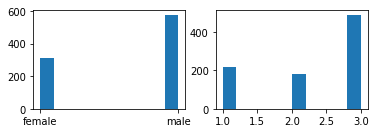

In [20]:
# Sex
plt.subplot(2, 2, 1)
plt.hist(trData['Sex'])

# Pclass 
plt.subplot(2, 2, 2)
plt.hist(trData['Pclass'])

plt.show()

# Cleaning

In [ ]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

In [ ]:
for data in data_list:
    #data['Age'].fillna(trData['Age'].median(), inplace = True)
    data['Embarked'].fillna(trData['Embarked'].mode()[0], inplace = True)

In [ ]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

In [ ]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

In [ ]:
PclassVsFare = combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).mean()
PclassVsFare

In [ ]:
testData['Pclass'][testData['Fare'].isnull()] 

In [ ]:
# The passenger with missing class has a Pclass of 3 whose average Fare is 13.67 
testData['Fare'].fillna(PclassVsFare.loc[2,'Fare'], inplace = True);

In [ ]:
for data in data_list:
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
testData.head()

In [ ]:
testData['Title'].value_counts()

In [ ]:
trData['Title'].value_counts()

In [ ]:
for data in data_list:
    data['Title'] = data['Title'].replace(['Lady', 'Sir', 'the Countess'], 'Royal')
    data['Title'] = data['Title'].replace(['Ms', 'Mlle'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

In [ ]:
trData['Title'].value_counts()

In [ ]:
testData['Title'].value_counts()

In [ ]:
for data in data_list:
    data['Nfamily'] = data['Parch'] + data['SibSp'] + 1

In [ ]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

In [ ]:
combinedData.loc[combinedData['Ticket'] == 'A/5. 851']

In [ ]:
combinedData['FamilyName'] = combinedData.Name.str.extract('(\w+),', expand = False)
trData['FamilyName'] = trData.Name.str.extract('(\w+),', expand = False)
testData['FamilyName'] = testData.Name.str.extract('(\w+),', expand = False)

In [ ]:
combinedData['FamilyName'].value_counts()

In [ ]:
ticket_counts = combinedData['Ticket'].value_counts()
ticket_unique = combinedData['Ticket'].value_counts().index

In [ ]:
temp_surv_array = []
for i in range(0, len(ticket_unique)):
    expression1 = (((testData['Ticket'] == ticket_unique[i]).sum() > 0) & (((trData['Ticket'] == ticket_unique[i]).sum()) > 1))
    expression2 = (((testData['Ticket'] == ticket_unique[i]).sum() > 0) & (((trData['Ticket'] == ticket_unique[i]).sum()) == 1))
    if expression1:
        if trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean() > 0.75:
            survival_rate_i =  1
        elif 0.5 <= trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean() <=0.75:
            survival_rate_i = 0.5
        elif 0.25 <= trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean() < 0.5:
            survival_rate_i = 0.25
        else:
            survival_rate_i = 0
    elif expression2:
        survival_rate_i =  0.5 * trData.loc[trData['Ticket'] == ticket_unique[i], 'Survived'].mean()
    else:
        survival_rate_i = -1
    temp_surv_array.append(survival_rate_i)

In [ ]:
myDict = dict(zip(ticket_unique, temp_surv_array))

In [ ]:
for data in data_list:
    data['TicketSurvivalRate'] = data['Ticket'].apply(lambda x: myDict[x])
testData['TicketSurvivalRate'].fillna(0, inplace = True);

In [ ]:
labelName = 'FamilyName'
family_counts = combinedData[labelName].value_counts()
family_unique = combinedData[labelName].value_counts().index
temp_surv_array = []
for i in range(0, len(family_unique)):
    expression1 = (((testData[labelName] == family_unique[i]).sum() > 0) & (((trData[labelName] == family_unique[i]).sum()) > 1))
    expression2 = (((testData[labelName] == family_unique[i]).sum() > 0) & (((trData[labelName] == family_unique[i]).sum()) == 1))
    if expression1:
        if trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean() > 0.75:
            survival_rate_i =  1
        elif 0.5 <= trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean() <=0.75:
            survival_rate_i = 0.5
        elif 0.25 <= trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean() < 0.5:
            survival_rate_i = 0.25
        else:
            survival_rate_i = 0
    elif expression2:
        survival_rate_i =  0.5 * trData.loc[trData[labelName] == family_unique[i], 'Survived'].mean()
    else:
        survival_rate_i = -1
    temp_surv_array.append(survival_rate_i)
myDict = dict(zip(family_unique, temp_surv_array))
for data in data_list:
    data['FamilySurvivalRate'] = data[labelName].apply(lambda x: myDict[x])

In [ ]:
trData.head()

In [ ]:
sns.barplot(x = 'TicketSurvivalRate', y = 'Survived', data = trData)
plt.show()

In [ ]:
trData['TicketSurvivalRate'].value_counts()

In [ ]:
sns.barplot(x = 'FamilySurvivalRate', y = 'Survived', data = trData)
plt.show()

In [ ]:
combinedData.loc[combinedData['FamilyName'] == 'Asplund'][['Name', 'Nfamily', 'Survived','Ticket']]

In [ ]:
title_vs_age = combinedData[['Title', 'Age']].groupby(['Title'], as_index = False).mean()
title_vs_age

In [ ]:
title_vs_age.loc[title_vs_age['Title'] == 'Master', 'Age'][0]

In [ ]:
# temp_array = []
# for data in data_list:
#     for i in range(len(data)):
#         if np.isnan(data['Age'][i]):
#             colVec = (data['Title'] == data['Title'][i]) & (data['Embarked'] == data['Embarked'][i]) & (data['Pclass'] == data['Pclass'][i]) 
#             temp_array.append(data.loc[colVec, 'Age'].mean())
#         else:
#             temp_array.append(data['Age'][i])
#     data['Age'] = temp_array
#     temp_array = []

In [ ]:
for i in range(0, len(title_vs_age)):
    title_temp = title_vs_age.loc[i]['Title']
    trData.loc[trData['Age'].isnull() & (trData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]
    testData.loc[testData['Age'].isnull() & (testData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]

### Cabin code; missing cabin code is converted to 0, and existing ones converted to 1

In [ ]:
for data in data_list:
    data['CabinCode'] = (data['Cabin'].notnull()) * 1

## Transfer categorial values to discrete values

In [ ]:
trData.head()

In [ ]:
trData['Title'].unique()

### Define the age bins and fare bins

In [ ]:
age_bins = [0, 12, 19, 25, 35, 60, np.inf]
age_labels = ['Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
trData['AgeGroup'] = pd.cut(trData["Age"], age_bins, labels = age_labels)
testData['AgeGroup'] = pd.cut(testData["Age"], age_bins, labels = age_labels)

In [ ]:
trData['AgeGroup'].value_counts()

In [ ]:
sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData)
plt.show()

In [ ]:
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [ ]:
trData['Fare'].describe()

In [ ]:
pd.qcut(trData['Fare'], 3).value_counts()

In [ ]:
combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).median()

In [ ]:
trData['Fare'].describe()
fare_bins = [-0.1,  7.5, 15, 40, 70, np.inf]
fare_labels = ['Cheap', 'BelowAverage', 'Average', 'AboveAverage','Expensive']
trData['FareBin'] = pd.cut(trData['Fare'], fare_bins, labels = fare_labels)
testData['FareBin'] = pd.cut(testData['Fare'], fare_bins, labels = fare_labels)

In [ ]:
sns.barplot(x = 'FareBin', y = 'Survived', data = trData)
plt.show()

In [ ]:
# Check variation of survival rate vs agegroup within the three Pclasses (this helps picking the right age_bins)
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [ ]:
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'Embarked', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [ ]:
trData['FareBin'].value_counts()

In [ ]:
TicketVec = []
for data in data_list:
    for i in list(data.Ticket):
        if not i.isdigit() :
            TicketVec.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            TicketVec.append("X")
    data["TicketLetter"] = TicketVec
    data["TicketLetter"].head()
    TicketVec = []

In [ ]:
trData['TicketLetter'].head()

In [ ]:
for data in data_list:
    data['TicketPrefix'] = data['TicketLetter'].apply(lambda x: 'Rare' if data['TicketLetter'].value_counts()[x] < 6 else x)

In [ ]:
testData['TicketPrefix'].value_counts()

In [ ]:
trData['TicketPrefix'].value_counts()

In [ ]:
testData['Ticket'].value_counts()

In [ ]:
sns.barplot(x = 'TicketPrefix', y = 'Survived', data = trData)
plt.show()

In [ ]:
label = LabelEncoder()
for data in data_list:
    #data['FareBinCode'] = label.fit_transform(data['FareBin'])
    #data['AgeBinCode'] = label.fit_transform(data['AgeBin']) 
    #data['TicketCode'] = label.fit_transform(data['TicketPrefix'])
    data['TicketCode'] = data['TicketPrefix'].replace(['X','Rare', 'PC', 'CA', 'A5', 'SOTONOQ', 'STONO', 'WC', 'SCPARIS', 'A4', 'SOC', 'STONO2']
                                                      , [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    data['SexCode'] = data['Sex'].replace(['female', 'male'], [0, 1])
    data['EmbarkedCode'] = data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
    data['TitleCode'] = data['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master','Royal', 'Rare'], [0, 1, 2, 3, 4, 5])
    data['IsAlone'] = 1
    data.loc[data['Nfamily'] > 1, 'IsAlone'] = 0
    data['AgeGroup'] = data['AgeGroup'].replace(age_labels,[0, 1, 2, 3, 4, 5])
    data['FareBin'] = data['FareBin'].replace(fare_labels, [0, 1, 2, 3, 4])

# Statistical Analysis and feature engineering

In [ ]:
trData[['Nfamily', 'Survived']].groupby(['Nfamily'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
trData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
trData[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

In [ ]:
trData[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean()

In [ ]:
trData['SibSp'].value_counts()

In [ ]:
trData[['Pclass','Fare','Survived']].groupby(['Pclass'], as_index = False).mean()

In [ ]:
sns.barplot(x="Pclass", y="Survived", data=trData)
plt.show()
sns.barplot(x="EmbarkedCode", y="Survived", data=trData)
plt.show()
sns.barplot(x = "CabinCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "TitleCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "AgeGroup", y = "Survived", data = trData)
plt.show()

In [ ]:
pd.crosstab(trData['Sex'], trData['Survived'])

In [ ]:
trData[['TitleCode','Survived']].groupby(['TitleCode'], as_index = False).mean()

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData)
plt.show()

# Classification models, cross-validation, and parameter tuning

In [ ]:
selectedFeatures = ['Pclass', 'SexCode', 'AgeGroup', 'TitleCode', 'Nfamily', 'IsAlone', 'EmbarkedCode', 'FareBin'
                    ,'CabinCode', 'TicketCode', 'TicketSurvivalRate']; # IsAlone is a redundant feature and I think it should be removed, however, with that I got a better submission accuracy on Kaggle
X = trData[selectedFeatures]
y = trData['Survived']

In [ ]:
X.head()

## Cross-validation
First a cross validation; we split the training set (trData) to a test size of 20 percent and train size of 0.8. We do a cross validation on 0.8 set. 

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state=1)

## From the above results we try a voting 
### Comparing different possible voting lists
We try different voting lists, and pick the one with the highest accuracy. Once we decide about the best voting list, we run the gridsearchCV this time for the whole data set

In [ ]:
# voting_list = [('grBoost', clf_list[2]), ('randforest', clf_list[3]), ('extree', clf_list[4]), ('knn', clf_list[5])]
# # voting_list = [('randforest', clf_list[3]), ('extree', clf_list[4]), ('grBoost', clf_list[2])]
# voting_list = [('a', clf_list[2]), ('c', clf_list[3]), ('d', clf_list[3])]
# votingC = ensemble.VotingClassifier(estimators=voting_list, voting='soft', n_jobs=4)
# votingC = votingC.fit(Xtrain, ytrain)
# arpredict = votingC.predict(Xtest)
# print(metrics.accuracy_score(ytest, arpredict))
# best_voting_list = votingC

The above number is the approximated accuracy that we should when testing the real data. However, of course we should use all the available results for fitting so we replace Xtrain and ytrain with X and y

In [ ]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .4, train_size = .6, random_state = 0) 
grid_bool = [True, False]
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13,20, 30, 40]
grid_ratio_list = [.1, .25, .5, .75, 1.0]
grid_n_neighbors = range(1, 20)
grid_n_estimator = [10, 50, 100, 300]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

clf_list = [LogisticRegression(), SVC(), ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), 
            ensemble.ExtraTreesClassifier(), KNeighborsClassifier()]
grid_param_list = [[{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'C': C_param_range,
            #'solver': ['newton-cg','lbfgs','liblinear']
             }],
             [{
            'C': C_param_range,
             'gamma': grid_ratio_list
             }],
             [{
              'max_depth': grid_max_depth   
             }], 
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
              'n_neighbors': grid_n_neighbors
             }]
             ]
best_scores_list = []
for clf, param in zip (clf_list, grid_param_list):
    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc'
                                              , n_jobs = 4)
    best_search.fit(X, y) # Note X, y NOT Xtrain, ytrain
    best_param = best_search.best_params_
    best_score = best_search.best_score_
    print('The best parameter for {} is {} with a runtime of seconds with a score of {}'.format(clf.__class__.__name__, best_param, best_score))
    clf.set_params(**best_param) 
    best_scores_list.append(best_score)
print("--"*45, "\nMax cross-validation score is:", max(best_scores_list))
print("--"*45, "\nAverage cross-validation score is:", sum(sorted(best_scores_list, reverse=True)[0:3]) / 3)

In [ ]:
best_voting_list = [('a', clf_list[2]), ('c', clf_list[3]), ('d', clf_list[4])]
# best_voting_list = [('a', clf_list[2])]
votingC = ensemble.VotingClassifier(estimators=best_voting_list, voting='soft', n_jobs=4)
votingC = votingC.fit(X, y) # Note we fit the Whole X, y
arpredict = votingC.predict(Xtest)
print(metrics.accuracy_score(ytest, arpredict))

In [ ]:
testDataTemp = testData[selectedFeatures]
arPredict = votingC.predict(testDataTemp)

In [ ]:
testDataTemp.head()

In [ ]:
yPredict = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived': arPredict})
yPredict.to_csv('../predictions.csv', index = False)

In [ ]:
X.head()

In [ ]:
testDataTemp.head()

In [ ]:
now = pd.read_csv('../predictions.csv')
best = pd.read_csv('../predictions_score82296.csv')
print(len(testData.loc[now['Survived'] != best['Survived']]))
testData.loc[now['Survived'] != best['Survived'], ['Ticket', 'Nfamily', 'TicketSurvivalRate']]

In [ ]:
trData.loc[trData['Ticket'] == '110813']

In [ ]:
testData.loc[testData['Ticket'] == '110813']

In [ ]:
yPredict.loc[now['Survived'] != best['Survived']]